# k-scheduling tests

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation, FasterAmplitudeEstimation
from operators import *

In [2]:
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def good_state(state):
    bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
    return (state in bin_marked)

problem = EstimationProblem(
    state_preparation=A(n),  # A operator
    grover_operator=Q(n, marked),  # Q operator
    objective_qubits=range(n),
    is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 100

## IQAE: attempt exponential decay in the number of shots per iteration to account for deeper circuits.

In [5]:
# TODO: package this in a function to make it nicer / generalize

# n_trials = 100
# max_depth_log2 = 5
# queries = np.zeros((max_depth_log2-1, n_trials))
# errs = np.zeros((max_depth_log2-1, n_trials))

# for i in range(2,max_depth_log2+1):
#     for j in range(n_trials):
#         mlae = MLAE(range(i), quantum_instance=aer_sim)
#         result = mlae.estimate(problem)
#         queries[i-2,j] = result.num_oracle_queries
#         errs[i-2,j] = abs(k/N - result.estimation)

In [6]:
# parameters for IQAE
alpha = 0.05
confint_method = 'chernoff'

In [7]:
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]
# num_experiments = 100

iae_results = [] 

# for i in range(num_experiments):
for j, epsilon in enumerate(epsilons):
    print('ε:',epsilon)
    IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, confint_method=confint_method, quantum_instance=aer_sim)
    iae_result = IAE.estimate(problem)
    iae_results.append(iae_result)
    print()

ε: 0.01
T: 7

Iteration 1
  k_i: 0
Iteration 2
  k_i: 2
Iteration 3
  k_i: 13

ε: 0.001
T: 10

Iteration 1
  k_i: 0
Iteration 2
  k_i: 1
Iteration 3
  k_i: 6
Iteration 4
  k_i: 34
Iteration 5
  k_i: 168

ε: 0.0001
T: 13

Iteration 1
  k_i: 0
Iteration 2
  k_i: 2
Iteration 3
  k_i: 12
Iteration 4
  k_i: 66
Iteration 5
  k_i: 351
Iteration 6
  k_i: 1823

ε: 1e-05
T: 17

Iteration 1
  k_i: 0
Iteration 2
  k_i: 2
Iteration 3
  k_i: 11
Iteration 4
  k_i: 59
Iteration 5
  k_i: 321
Iteration 6
  k_i: 1691
Iteration 7
  k_i: 8019

ε: 1e-06
T: 20

Iteration 1
  k_i: 0
Iteration 2
  k_i: 2
Iteration 3
  k_i: 13
Iteration 4
  k_i: 65
Iteration 5
  k_i: 331
Iteration 6
  k_i: 1759
Iteration 7
  k_i: 9150
Iteration 8
  k_i: 45136
Iteration 9
  k_i: 239606



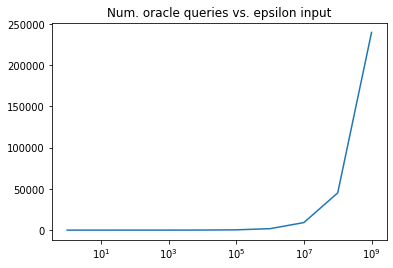

In [8]:
x = iae_results[-1].powers
plt.plot([10**i for i in np.arange(len(x))], x)
plt.xscale('log')
plt.title('Num. oracle queries vs. epsilon input')
plt.show()

In [9]:
IAE_RESULT = iae_results

In [10]:
iae_epsilon = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in IAE_RESULT]
iae_results = [res.estimation for res in IAE_RESULT]
iae_nshots  = [res.num_oracle_queries for res in IAE_RESULT]

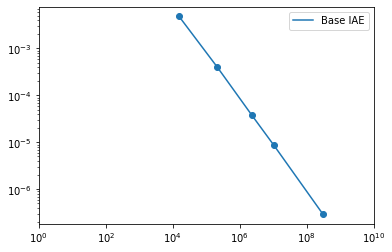

In [11]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(iae_nshots, iae_epsilon)
ax.plot(iae_nshots, iae_epsilon)

ax.legend(['Base IAE'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlim(1, 10**10)
plt.show()